In [1]:
from dataset import LFWDataset # .py to load LFW dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
import torchprofile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
seed = 25

batch_size = 8
n_epochs = 150
learning_rate = 0.001

In [3]:
data = LFWDataset(
    faces_folder="../data/faces",
    smiling_labels_file="../data/SMILE_list.txt",
    non_smiling_labels_file="../data/NON-SMILE_list.txt",
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),       # mean
                            (0.5, 0.5, 0.5))        # std
    ])
)

In [4]:
# separate non-smiling faces and smiling faces
non_smiling_faces = [data[i] for i in range(len(data)) if data.labels[i] == 0]
len(non_smiling_faces)

603

In [5]:
smiling_faces = [data[i] for i in range(len(data)) if data.labels[i] == 1]
len(smiling_faces)

600

In [6]:
# split dataset into train and validation sets
train_size = int(0.8 * len(non_smiling_faces))
train_dataset_0, test_dataset_0 = torch.utils.data.random_split(non_smiling_faces, [train_size, len(non_smiling_faces) - train_size], generator=torch.Generator().manual_seed(seed))

train_smiling, test_smiling = torch.utils.data.random_split(smiling_faces, [train_size, len(smiling_faces) - train_size], generator=torch.Generator().manual_seed(seed))


In [7]:
X_test = torch.stack([non_smiling_faces[i][0] for i in test_dataset_0.indices])
X_train = torch.stack([non_smiling_faces[i][0] for i in train_dataset_0.indices])

X_test_smiling = torch.stack([smiling_faces[i][0] for i in test_smiling.indices])
X_train_smiling = torch.stack([smiling_faces[i][0] for i in train_smiling.indices])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
X_test = X_test.to(device)

X_test_smiling = X_test_smiling.to(device)
X_train_smiling = X_train_smiling.to(device)

In [9]:
train_dataset = TensorDataset(X_train, X_train)
smiling_train_dataset = TensorDataset(X_train_smiling, X_train_smiling)


val_size = int(0.15 * len(data))
train_data, val_data = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size], generator=torch.Generator().manual_seed(seed))
smiling_tr_data, smiling_val_data = torch.utils.data.random_split(smiling_train_dataset, [len(smiling_train_dataset) - val_size, val_size], generator=torch.Generator().manual_seed(seed))

In [10]:
X_val = torch.stack([non_smiling_faces[i][0] for i in val_data.indices]).to(device)

X_val_smiling = torch.stack([smiling_faces[i][0] for i in smiling_val_data.indices]).to(device)


In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, X_test), batch_size=batch_size, shuffle=False)

In [12]:
def count_parameters(model):
    """Return total parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad) # only trainable params

In [13]:
def train_autoencoder(autoencoder, train_loader, val_loader, epochs=100, lr=0.01):
    """Train the autoencoder model."""
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder = autoencoder.to(device)
    
    # Define optimizer and loss function
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    criterion = nn.L1Loss()
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #optimizer, factor=0.5, patience=5
#) # decaying lr
    
    # Training loop
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training
        autoencoder.train()
        train_loss = 0
        for batch_data, batch_targets in train_loader:
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(batch_data)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data, batch_targets in val_loader:
                batch_data = batch_data.to(device)
                batch_targets = batch_targets.to(device)
                outputs = autoencoder(batch_data)
                loss = criterion(outputs, batch_targets)
                val_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")

        #scheduler.step(val_loss_avg)
    
    return train_losses, val_losses

In [14]:
def visualize_results(autoencoder, x_test, n=10):
    """Visualize original and reconstructed images."""
    # Encode and decode images from the test set.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder.eval()
    with torch.no_grad():
        decoded_imgs = autoencoder(x_test.to(device))

    # Convert to numpy for plotting (move to CPU first)
    x_test_np = (x_test.cpu().numpy() + 1) / 2
    decoded_imgs_np = (decoded_imgs.cpu().numpy() + 1) / 2

    # Plot the results
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test_np[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs_np[i].transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [15]:
def anomaly_accuracy(model, x_norm, x_anom, threshold=None):
    """
    Anomaly-detection accuracy using reconstruction error.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        # Compute reconstruction errors
        r_norm = torch.mean(torch.abs(model(x_norm.to(device)) - x_norm.to(device)), dim=(1,2,3))
        r_anom = torch.mean(torch.abs(model(x_anom.to(device)) - x_anom.to(device)), dim=(1,2,3))

    # labels: 0 = normal, 1 = anomaly
    labels = torch.cat([torch.zeros_like(r_norm), torch.ones_like(r_anom)])
    scores = torch.cat([r_norm, r_anom])

    # best accuracy threshold
    if threshold == None:
        thresholds = torch.linspace(scores.min(), scores.max(), 200)
        best_acc, best_th = 0, None
        for th in thresholds:
            preds = (scores > th).int()
            acc = (preds == labels).float().mean()
            if acc > best_acc:
                best_acc = acc
                best_th = th
        return best_acc.item(), best_th.item()
    
    preds = (scores > threshold).int()
    acc = (preds == labels).float().mean()
    return acc.item(), threshold


In [16]:
# Define the convolutional autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 64*64*3 --> 64*64*16
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # --> 32*32*32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # --> 16*16*64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # --> 8*8*128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # --> 4*4*256
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # 4*4*256 --> 8*8*256
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # --> 8*8*128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 16*16*128
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # --> 16*16*64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 32*32*64
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1), # --> 32*32*32
            nn.ReLU(),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False), # --> 64*64*32
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1), # --> 64*64*16
            nn.ReLU(),

            nn.Conv2d(16, 3, kernel_size=1, stride=1, padding=0), # --> 64*64*3
        )
        
        self.tanh = nn.Tanh()
    
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.tanh(decoded)
        return output


In [17]:
autoencoder = ConvAutoencoder()

start = time.perf_counter()

train_losses, val_losses = train_autoencoder(
    autoencoder, train_loader, val_loader,
    epochs=n_epochs, lr=learning_rate
)

# Ensure GPU ops complete before stopping timer
if torch.cuda.is_available():
    torch.cuda.synchronize()
end = time.perf_counter()

training_time = end - start

Training Progress:   1%|          | 1/150 [00:01<03:58,  1.60s/it]

Epoch 1/150, Train Loss: 0.2017, Val Loss: 0.1774


Training Progress:   2%|▏         | 3/150 [00:02<01:16,  1.91it/s]

Epoch 2/150, Train Loss: 0.1664, Val Loss: 0.1661
Epoch 3/150, Train Loss: 0.1578, Val Loss: 0.1485


Training Progress:   3%|▎         | 5/150 [00:02<00:47,  3.06it/s]

Epoch 4/150, Train Loss: 0.1505, Val Loss: 0.1380
Epoch 5/150, Train Loss: 0.1395, Val Loss: 0.1379


Training Progress:   5%|▍         | 7/150 [00:02<00:36,  3.90it/s]

Epoch 6/150, Train Loss: 0.1392, Val Loss: 0.1322
Epoch 7/150, Train Loss: 0.1398, Val Loss: 0.1326


Training Progress:   5%|▌         | 8/150 [00:03<00:34,  4.09it/s]

Epoch 8/150, Train Loss: 0.1434, Val Loss: 0.1588


Training Progress:   7%|▋         | 10/150 [00:03<00:31,  4.48it/s]

Epoch 9/150, Train Loss: 0.1329, Val Loss: 0.1288
Epoch 10/150, Train Loss: 0.1336, Val Loss: 0.1256


Training Progress:   8%|▊         | 12/150 [00:03<00:28,  4.85it/s]

Epoch 11/150, Train Loss: 0.1364, Val Loss: 0.1249
Epoch 12/150, Train Loss: 0.1290, Val Loss: 0.1205


Training Progress:   9%|▉         | 14/150 [00:04<00:27,  4.97it/s]

Epoch 13/150, Train Loss: 0.1302, Val Loss: 0.1218
Epoch 14/150, Train Loss: 0.1312, Val Loss: 0.1236


Training Progress:  10%|█         | 15/150 [00:04<00:27,  4.95it/s]

Epoch 15/150, Train Loss: 0.1245, Val Loss: 0.1176


Training Progress:  11%|█▏        | 17/150 [00:04<00:27,  4.92it/s]

Epoch 16/150, Train Loss: 0.1284, Val Loss: 0.1374
Epoch 17/150, Train Loss: 0.1257, Val Loss: 0.1294


Training Progress:  13%|█▎        | 19/150 [00:05<00:26,  4.89it/s]

Epoch 18/150, Train Loss: 0.1212, Val Loss: 0.1152
Epoch 19/150, Train Loss: 0.1227, Val Loss: 0.1165


Training Progress:  14%|█▍        | 21/150 [00:05<00:25,  5.08it/s]

Epoch 20/150, Train Loss: 0.1181, Val Loss: 0.1189
Epoch 21/150, Train Loss: 0.1224, Val Loss: 0.1132


Training Progress:  15%|█▍        | 22/150 [00:05<00:25,  5.12it/s]

Epoch 22/150, Train Loss: 0.1255, Val Loss: 0.1157


Training Progress:  15%|█▌        | 23/150 [00:06<00:25,  4.92it/s]

Epoch 23/150, Train Loss: 0.1200, Val Loss: 0.1237


Training Progress:  16%|█▌        | 24/150 [00:06<00:26,  4.74it/s]

Epoch 24/150, Train Loss: 0.1198, Val Loss: 0.1124


Training Progress:  17%|█▋        | 26/150 [00:06<00:25,  4.81it/s]

Epoch 25/150, Train Loss: 0.1138, Val Loss: 0.1092
Epoch 26/150, Train Loss: 0.1152, Val Loss: 0.1160


Training Progress:  18%|█▊        | 27/150 [00:06<00:25,  4.81it/s]

Epoch 27/150, Train Loss: 0.1165, Val Loss: 0.1160


Training Progress:  19%|█▉        | 29/150 [00:07<00:24,  4.93it/s]

Epoch 28/150, Train Loss: 0.1109, Val Loss: 0.1155
Epoch 29/150, Train Loss: 0.1133, Val Loss: 0.1096


Training Progress:  21%|██        | 31/150 [00:07<00:23,  5.12it/s]

Epoch 30/150, Train Loss: 0.1139, Val Loss: 0.1267
Epoch 31/150, Train Loss: 0.1087, Val Loss: 0.1108


Training Progress:  22%|██▏       | 33/150 [00:08<00:22,  5.16it/s]

Epoch 32/150, Train Loss: 0.1094, Val Loss: 0.1109
Epoch 33/150, Train Loss: 0.1081, Val Loss: 0.1091


Training Progress:  23%|██▎       | 34/150 [00:08<00:22,  5.22it/s]

Epoch 34/150, Train Loss: 0.1110, Val Loss: 0.1090


Training Progress:  23%|██▎       | 35/150 [00:08<00:23,  4.93it/s]

Epoch 35/150, Train Loss: 0.1117, Val Loss: 0.1185


Training Progress:  25%|██▍       | 37/150 [00:08<00:23,  4.89it/s]

Epoch 36/150, Train Loss: 0.1063, Val Loss: 0.1052
Epoch 37/150, Train Loss: 0.1182, Val Loss: 0.1138


Training Progress:  26%|██▌       | 39/150 [00:09<00:22,  5.02it/s]

Epoch 38/150, Train Loss: 0.1066, Val Loss: 0.1017
Epoch 39/150, Train Loss: 0.1086, Val Loss: 0.1084


Training Progress:  27%|██▋       | 41/150 [00:09<00:21,  5.11it/s]

Epoch 40/150, Train Loss: 0.1035, Val Loss: 0.1032
Epoch 41/150, Train Loss: 0.1014, Val Loss: 0.1041


Training Progress:  28%|██▊       | 42/150 [00:09<00:22,  4.89it/s]

Epoch 42/150, Train Loss: 0.1006, Val Loss: 0.1053


Training Progress:  29%|██▊       | 43/150 [00:10<00:23,  4.58it/s]

Epoch 43/150, Train Loss: 0.1056, Val Loss: 0.1092


Training Progress:  29%|██▉       | 44/150 [00:10<00:24,  4.40it/s]

Epoch 44/150, Train Loss: 0.1067, Val Loss: 0.1040


Training Progress:  30%|███       | 45/150 [00:10<00:23,  4.45it/s]

Epoch 45/150, Train Loss: 0.1027, Val Loss: 0.1049


Training Progress:  31%|███       | 46/150 [00:10<00:24,  4.16it/s]

Epoch 46/150, Train Loss: 0.0984, Val Loss: 0.1092


Training Progress:  31%|███▏      | 47/150 [00:11<00:25,  4.01it/s]

Epoch 47/150, Train Loss: 0.0962, Val Loss: 0.1003


Training Progress:  32%|███▏      | 48/150 [00:11<00:24,  4.10it/s]

Epoch 48/150, Train Loss: 0.0970, Val Loss: 0.1020


Training Progress:  33%|███▎      | 49/150 [00:11<00:23,  4.22it/s]

Epoch 49/150, Train Loss: 0.1004, Val Loss: 0.1070


Training Progress:  33%|███▎      | 50/150 [00:11<00:22,  4.40it/s]

Epoch 50/150, Train Loss: 0.0969, Val Loss: 0.1032


Training Progress:  35%|███▍      | 52/150 [00:12<00:21,  4.59it/s]

Epoch 51/150, Train Loss: 0.0948, Val Loss: 0.1024
Epoch 52/150, Train Loss: 0.0975, Val Loss: 0.1067


Training Progress:  35%|███▌      | 53/150 [00:12<00:21,  4.59it/s]

Epoch 53/150, Train Loss: 0.0970, Val Loss: 0.1020


Training Progress:  36%|███▌      | 54/150 [00:12<00:22,  4.33it/s]

Epoch 54/150, Train Loss: 0.0934, Val Loss: 0.0963


Training Progress:  37%|███▋      | 55/150 [00:13<00:22,  4.19it/s]

Epoch 55/150, Train Loss: 0.0958, Val Loss: 0.1094


Training Progress:  38%|███▊      | 57/150 [00:13<00:21,  4.35it/s]

Epoch 56/150, Train Loss: 0.0936, Val Loss: 0.1003
Epoch 57/150, Train Loss: 0.0949, Val Loss: 0.0994


Training Progress:  39%|███▉      | 59/150 [00:13<00:19,  4.77it/s]

Epoch 58/150, Train Loss: 0.0915, Val Loss: 0.0980
Epoch 59/150, Train Loss: 0.0885, Val Loss: 0.0959


Training Progress:  41%|████      | 61/150 [00:14<00:18,  4.91it/s]

Epoch 60/150, Train Loss: 0.0884, Val Loss: 0.0982
Epoch 61/150, Train Loss: 0.0921, Val Loss: 0.0961


Training Progress:  41%|████▏     | 62/150 [00:14<00:20,  4.35it/s]

Epoch 62/150, Train Loss: 0.0863, Val Loss: 0.0979


Training Progress:  42%|████▏     | 63/150 [00:14<00:21,  4.08it/s]

Epoch 63/150, Train Loss: 0.0842, Val Loss: 0.0962


Training Progress:  43%|████▎     | 64/150 [00:15<00:20,  4.22it/s]

Epoch 64/150, Train Loss: 0.0886, Val Loss: 0.1211


Training Progress:  43%|████▎     | 65/150 [00:15<00:21,  4.04it/s]

Epoch 65/150, Train Loss: 0.0892, Val Loss: 0.1001


Training Progress:  45%|████▍     | 67/150 [00:15<00:19,  4.28it/s]

Epoch 66/150, Train Loss: 0.0889, Val Loss: 0.1025
Epoch 67/150, Train Loss: 0.0880, Val Loss: 0.0934


Training Progress:  45%|████▌     | 68/150 [00:15<00:18,  4.49it/s]

Epoch 68/150, Train Loss: 0.0844, Val Loss: 0.0937


Training Progress:  47%|████▋     | 70/150 [00:16<00:17,  4.69it/s]

Epoch 69/150, Train Loss: 0.0850, Val Loss: 0.0945
Epoch 70/150, Train Loss: 0.0857, Val Loss: 0.0951


Training Progress:  48%|████▊     | 72/150 [00:16<00:16,  4.86it/s]

Epoch 71/150, Train Loss: 0.0817, Val Loss: 0.0943
Epoch 72/150, Train Loss: 0.0835, Val Loss: 0.0948


Training Progress:  49%|████▊     | 73/150 [00:16<00:15,  4.96it/s]

Epoch 73/150, Train Loss: 0.0837, Val Loss: 0.0975


Training Progress:  49%|████▉     | 74/150 [00:17<00:16,  4.74it/s]

Epoch 74/150, Train Loss: 0.0829, Val Loss: 0.0955


Training Progress:  50%|█████     | 75/150 [00:17<00:16,  4.65it/s]

Epoch 75/150, Train Loss: 0.0839, Val Loss: 0.0946


Training Progress:  51%|█████     | 76/150 [00:17<00:15,  4.65it/s]

Epoch 76/150, Train Loss: 0.0820, Val Loss: 0.0952


Training Progress:  52%|█████▏    | 78/150 [00:18<00:15,  4.74it/s]

Epoch 77/150, Train Loss: 0.0846, Val Loss: 0.1015
Epoch 78/150, Train Loss: 0.0816, Val Loss: 0.0954


Training Progress:  53%|█████▎    | 80/150 [00:18<00:14,  4.80it/s]

Epoch 79/150, Train Loss: 0.0838, Val Loss: 0.0957
Epoch 80/150, Train Loss: 0.0817, Val Loss: 0.0961


Training Progress:  54%|█████▍    | 81/150 [00:18<00:14,  4.86it/s]

Epoch 81/150, Train Loss: 0.0856, Val Loss: 0.0938


Training Progress:  55%|█████▌    | 83/150 [00:19<00:13,  4.89it/s]

Epoch 82/150, Train Loss: 0.0819, Val Loss: 0.0969
Epoch 83/150, Train Loss: 0.0814, Val Loss: 0.0939


Training Progress:  57%|█████▋    | 85/150 [00:19<00:13,  4.94it/s]

Epoch 84/150, Train Loss: 0.0778, Val Loss: 0.0917
Epoch 85/150, Train Loss: 0.0805, Val Loss: 0.0938


Training Progress:  58%|█████▊    | 87/150 [00:19<00:12,  5.03it/s]

Epoch 86/150, Train Loss: 0.0791, Val Loss: 0.0930
Epoch 87/150, Train Loss: 0.0822, Val Loss: 0.0953


Training Progress:  59%|█████▉    | 89/150 [00:20<00:12,  4.86it/s]

Epoch 88/150, Train Loss: 0.0815, Val Loss: 0.0937
Epoch 89/150, Train Loss: 0.0805, Val Loss: 0.0978


Training Progress:  60%|██████    | 90/150 [00:20<00:11,  5.00it/s]

Epoch 90/150, Train Loss: 0.0783, Val Loss: 0.0969


Training Progress:  61%|██████▏   | 92/150 [00:20<00:11,  5.16it/s]

Epoch 91/150, Train Loss: 0.0771, Val Loss: 0.0922
Epoch 92/150, Train Loss: 0.0777, Val Loss: 0.0938


Training Progress:  63%|██████▎   | 94/150 [00:21<00:10,  5.10it/s]

Epoch 93/150, Train Loss: 0.0786, Val Loss: 0.0936
Epoch 94/150, Train Loss: 0.0781, Val Loss: 0.0926


Training Progress:  64%|██████▍   | 96/150 [00:21<00:10,  5.19it/s]

Epoch 95/150, Train Loss: 0.0788, Val Loss: 0.0925
Epoch 96/150, Train Loss: 0.0802, Val Loss: 0.0928


Training Progress:  65%|██████▌   | 98/150 [00:22<00:10,  5.11it/s]

Epoch 97/150, Train Loss: 0.0802, Val Loss: 0.0958
Epoch 98/150, Train Loss: 0.0791, Val Loss: 0.0969


Training Progress:  66%|██████▌   | 99/150 [00:22<00:10,  4.92it/s]

Epoch 99/150, Train Loss: 0.0799, Val Loss: 0.0996


Training Progress:  67%|██████▋   | 101/150 [00:22<00:10,  4.89it/s]

Epoch 100/150, Train Loss: 0.0796, Val Loss: 0.0922
Epoch 101/150, Train Loss: 0.0778, Val Loss: 0.0928


Training Progress:  69%|██████▊   | 103/150 [00:23<00:09,  4.83it/s]

Epoch 102/150, Train Loss: 0.0770, Val Loss: 0.0955
Epoch 103/150, Train Loss: 0.0761, Val Loss: 0.0934


Training Progress:  70%|███████   | 105/150 [00:23<00:09,  5.00it/s]

Epoch 104/150, Train Loss: 0.0765, Val Loss: 0.0936
Epoch 105/150, Train Loss: 0.0791, Val Loss: 0.0969


Training Progress:  71%|███████▏  | 107/150 [00:23<00:08,  4.82it/s]

Epoch 106/150, Train Loss: 0.0767, Val Loss: 0.0935
Epoch 107/150, Train Loss: 0.0760, Val Loss: 0.0942


Training Progress:  73%|███████▎  | 109/150 [00:24<00:08,  4.91it/s]

Epoch 108/150, Train Loss: 0.0743, Val Loss: 0.0961
Epoch 109/150, Train Loss: 0.0727, Val Loss: 0.0966


Training Progress:  73%|███████▎  | 110/150 [00:24<00:08,  4.95it/s]

Epoch 110/150, Train Loss: 0.0734, Val Loss: 0.0925


Training Progress:  75%|███████▍  | 112/150 [00:24<00:07,  5.05it/s]

Epoch 111/150, Train Loss: 0.0732, Val Loss: 0.0962
Epoch 112/150, Train Loss: 0.0735, Val Loss: 0.0952


Training Progress:  75%|███████▌  | 113/150 [00:25<00:07,  4.90it/s]

Epoch 113/150, Train Loss: 0.0744, Val Loss: 0.0991


Training Progress:  76%|███████▌  | 114/150 [00:25<00:07,  4.79it/s]

Epoch 114/150, Train Loss: 0.0754, Val Loss: 0.0929


Training Progress:  77%|███████▋  | 115/150 [00:25<00:07,  4.79it/s]

Epoch 115/150, Train Loss: 0.0778, Val Loss: 0.0939


Training Progress:  77%|███████▋  | 116/150 [00:25<00:07,  4.72it/s]

Epoch 116/150, Train Loss: 0.0751, Val Loss: 0.0992


Training Progress:  78%|███████▊  | 117/150 [00:25<00:07,  4.67it/s]

Epoch 117/150, Train Loss: 0.0749, Val Loss: 0.0930


Training Progress:  79%|███████▉  | 119/150 [00:26<00:06,  4.60it/s]

Epoch 118/150, Train Loss: 0.0782, Val Loss: 0.0962
Epoch 119/150, Train Loss: 0.0730, Val Loss: 0.0969


Training Progress:  80%|████████  | 120/150 [00:26<00:06,  4.76it/s]

Epoch 120/150, Train Loss: 0.0727, Val Loss: 0.0947


Training Progress:  81%|████████  | 121/150 [00:26<00:06,  4.69it/s]

Epoch 121/150, Train Loss: 0.0732, Val Loss: 0.0919


Training Progress:  81%|████████▏ | 122/150 [00:27<00:05,  4.74it/s]

Epoch 122/150, Train Loss: 0.0753, Val Loss: 0.0928


Training Progress:  83%|████████▎ | 124/150 [00:27<00:05,  4.81it/s]

Epoch 123/150, Train Loss: 0.0751, Val Loss: 0.0944
Epoch 124/150, Train Loss: 0.0719, Val Loss: 0.0937


Training Progress:  83%|████████▎ | 125/150 [00:27<00:05,  4.92it/s]

Epoch 125/150, Train Loss: 0.0737, Val Loss: 0.0986


Training Progress:  85%|████████▍ | 127/150 [00:28<00:04,  4.80it/s]

Epoch 126/150, Train Loss: 0.0719, Val Loss: 0.0930
Epoch 127/150, Train Loss: 0.0752, Val Loss: 0.1002


Training Progress:  86%|████████▌ | 129/150 [00:28<00:04,  4.80it/s]

Epoch 128/150, Train Loss: 0.0729, Val Loss: 0.0920
Epoch 129/150, Train Loss: 0.0714, Val Loss: 0.0929


Training Progress:  87%|████████▋ | 130/150 [00:28<00:04,  4.87it/s]

Epoch 130/150, Train Loss: 0.0736, Val Loss: 0.0971


Training Progress:  88%|████████▊ | 132/150 [00:29<00:03,  4.91it/s]

Epoch 131/150, Train Loss: 0.0734, Val Loss: 0.0934
Epoch 132/150, Train Loss: 0.0718, Val Loss: 0.0933


Training Progress:  89%|████████▉ | 134/150 [00:29<00:03,  5.11it/s]

Epoch 133/150, Train Loss: 0.0720, Val Loss: 0.0932
Epoch 134/150, Train Loss: 0.0693, Val Loss: 0.0920


Training Progress:  91%|█████████ | 136/150 [00:29<00:02,  5.20it/s]

Epoch 135/150, Train Loss: 0.0687, Val Loss: 0.0998
Epoch 136/150, Train Loss: 0.0696, Val Loss: 0.0949


Training Progress:  92%|█████████▏| 138/150 [00:30<00:02,  5.20it/s]

Epoch 137/150, Train Loss: 0.0708, Val Loss: 0.0959
Epoch 138/150, Train Loss: 0.0708, Val Loss: 0.0966


Training Progress:  93%|█████████▎| 139/150 [00:30<00:02,  5.04it/s]

Epoch 139/150, Train Loss: 0.0699, Val Loss: 0.0963


Training Progress:  93%|█████████▎| 140/150 [00:30<00:02,  4.81it/s]

Epoch 140/150, Train Loss: 0.0700, Val Loss: 0.0949


Training Progress:  95%|█████████▍| 142/150 [00:31<00:01,  4.86it/s]

Epoch 141/150, Train Loss: 0.0721, Val Loss: 0.0931
Epoch 142/150, Train Loss: 0.0694, Val Loss: 0.0948


Training Progress:  95%|█████████▌| 143/150 [00:31<00:01,  4.77it/s]

Epoch 143/150, Train Loss: 0.0697, Val Loss: 0.0921


Training Progress:  97%|█████████▋| 145/150 [00:31<00:01,  4.92it/s]

Epoch 144/150, Train Loss: 0.0702, Val Loss: 0.0938
Epoch 145/150, Train Loss: 0.0690, Val Loss: 0.0953


Training Progress:  98%|█████████▊| 147/150 [00:32<00:00,  5.09it/s]

Epoch 146/150, Train Loss: 0.0685, Val Loss: 0.0960
Epoch 147/150, Train Loss: 0.0684, Val Loss: 0.0927


Training Progress:  99%|█████████▊| 148/150 [00:32<00:00,  4.95it/s]

Epoch 148/150, Train Loss: 0.0694, Val Loss: 0.0950


Training Progress:  99%|█████████▉| 149/150 [00:32<00:00,  4.81it/s]

Epoch 149/150, Train Loss: 0.0700, Val Loss: 0.0928


Training Progress: 100%|██████████| 150/150 [00:32<00:00,  4.58it/s]

Epoch 150/150, Train Loss: 0.0687, Val Loss: 0.0955


In [18]:
training_time

32.76673779997509

In [19]:
autoencoder = autoencoder.to(device)
autoencoder.eval()

sample_input = next(iter(test_loader))[0][:1]

times = []

with torch.no_grad():
    for i in range(100):
        # Prepare input
        x = sample_input.to(device)

        # Start timer
        if device == "cuda":
            torch.cuda.synchronize()
        t0 = time.perf_counter()

        # Forward pass
        _ = autoencoder(x)

        # Finish
        if device == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()

        times.append((t1 - t0) * 1000)  # ms

        np.mean(times), np.std(times)

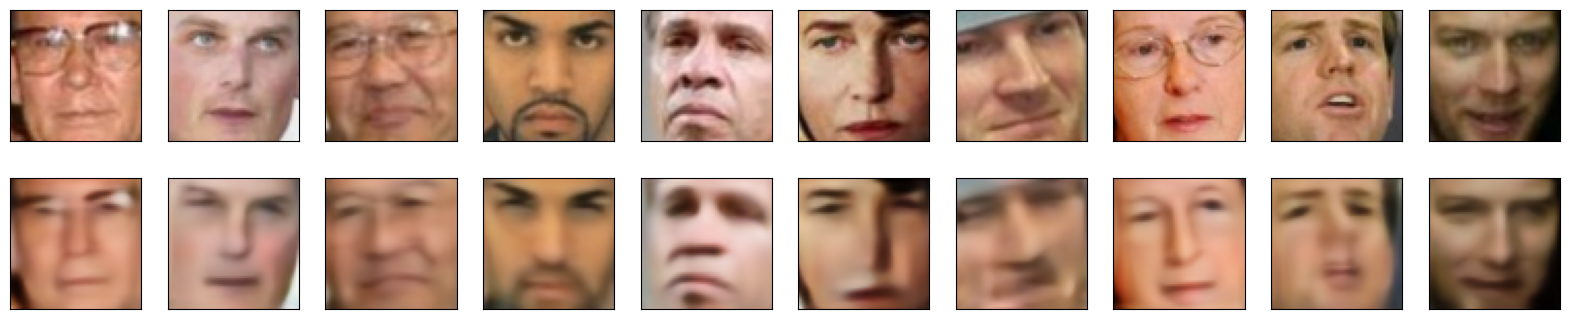

In [20]:
visualize_results(autoencoder, X_val)

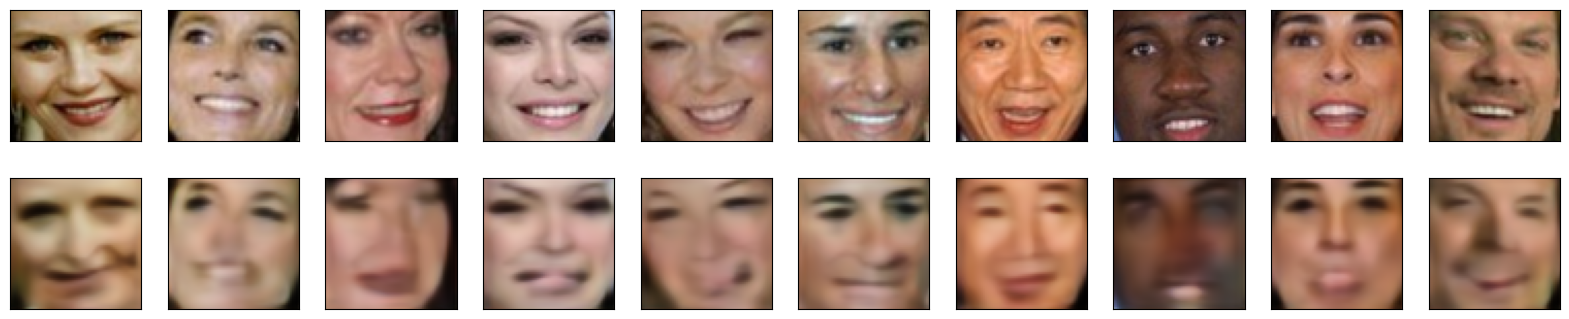

In [21]:
visualize_results(autoencoder, X_test_smiling)

In [22]:
# accuracy
acc, best_th = anomaly_accuracy(autoencoder, X_val, X_val_smiling)
acc, best_th

(0.7583333253860474, 0.0784701257944107)

In [24]:
acc_test, _ = anomaly_accuracy(autoencoder, X_test, X_test_smiling, threshold=best_th)
acc_test

0.6108786463737488